--- 
layout: post 
title: "Scrape immobilienscout24.de in parallel with python" 
---


In my last [post](https://domci.github.io/2019/05/14/immoscout-scraper.html) I described how to scape immoscout using python. I have run this scraper daily since quite a while now and collected quite some data.

Now it is time to look into that data and get some insights out of it:




In [1]:
import pandas as pd
import re
import sqlite3
import numpy as np
import pandas_profiling



conn = sqlite3.connect("sqlite/realty.db")
realty_details_df = pd.read_sql_query('select * from realties;', conn)
conn.close()



For that I first load some libraries, that I will need for querying and analizing the scraped immoscout classifieds. Then I query the data from sqlite:


In [2]:
realty_details_df.head(5)

,level_0,index,id,city_county,city_quarter,street,title,realty_type,floor,square_m,...,year_built,last_refurb,quality,heating_type,fuel_type,energy_consumption,energy_class,net_rent,gross_rent,scraped_ts
0,0.0,0,110713974,Hamburg,Altona-Nord,Glückel-von-Hameln-Straße 2,neue Wohnung - neues Glück,Etagenwohnung,0,"75,14",...,2019,0,0,0,0,0,0,1150,"1.370,66",2019-05-09 20:02:05.576285
1,1.0,1,110714010,Hamburg,Altona-Nord,Susanne-von-Paczensky-Straße 9,Grandiose 4-Zimmerwohung! ***Erstbezug***,Etagenwohnung,0,"99,39",...,2019,0,0,0,0,0,0,1440,"1.828,13",2019-05-09 20:02:05.952150
2,2.0,2,110247048,Hamburg,Altona-Nord,Susanne-von-Paczensky-Straße 7,Traumhafte Penthousewohnung! ***Erstbezug***,Etagenwohnung,0,"166,02",...,2019,0,0,0,0,0,0,2500,"3.090,15",2019-05-09 20:01:52.972958
3,3.0,3,110247042,Hamburg,Altona-Nord,Susanne-von-Paczensky-Straße 11,Geniale 3-Zimmerwohnung! ***Erstbezug***,Etagenwohnung,0,"97,65",...,2019,0,0,0,0,0,0,1470,"1.854,57",2019-05-09 20:01:52.835853
4,4.0,4,110714047,Hamburg,Altona-Nord,Eva-Rühmkorf-Straße 8,***Hervorragende 3-Zimmerwohnung*** Erstbezug!,Etagenwohnung,0,"86,04",...,2019,0,0,0,0,0,0,1300,"1.648,85",2019-05-09 20:01:52.821486


Well that looks like nice and clean data, but lets check data types to be sure:


In [3]:
print(realty_details_df.dtypes)

level_0               float64
index                   int64
id                      int64
city_county            object
city_quarter           object
street                 object
title                  object
realty_type            object
floor                  object
square_m               object
storage_m              object
num_rooms              object
num_bedrooms           object
num_baths              object
num_carparks           object
year_built             object
last_refurb            object
quality                object
heating_type           object
fuel_type              object
energy_consumption     object
energy_class           object
net_rent               object
gross_rent             object
scraped_ts             object
dtype: object


Oh my. All this data has weird data types. Pretty much all columns are of type 'object'. To really work with this we need to convert each column to its correct data type, e.g. numeric values as int or float and dates as dates etc.


In [2]:
non_decimal = re.compile(r'[^\d.]+')

realty_details_df.year_built = realty_details_df.year_built.replace('', '0')
realty_details_df.year_built = realty_details_df.year_built.apply(lambda x: non_decimal.sub('', str(x).replace(',','.')))
realty_details_df.square_m = realty_details_df.square_m.apply(lambda x: non_decimal.sub('', str(x).replace(',','.')))
realty_details_df.num_rooms = realty_details_df.num_rooms.apply(lambda x: non_decimal.sub('', str(x).replace(',','.')))
realty_details_df.storage_m = realty_details_df.storage_m.apply(lambda x: non_decimal.sub('', str(x).replace(',','.')))
realty_details_df.last_refurb = realty_details_df.last_refurb.apply(lambda x: non_decimal.sub('', str(x).replace(',','.')))
realty_details_df.energy_consumption = realty_details_df.energy_consumption.apply(lambda x: non_decimal.sub('', str(x).replace(',','.')))
realty_details_df.net_rent = realty_details_df.net_rent.apply(lambda x: non_decimal.sub('', str(x).replace('.','').replace(',','.')))
realty_details_df.gross_rent = realty_details_df.gross_rent.apply(lambda x: non_decimal.sub('', str(x).replace('.','').replace(',','.')))
realty_details_df.floor = realty_details_df.floor.apply(lambda x: str(x).split()[0])

realty_details_df = realty_details_df.replace('0', realty_details_df.replace(['0'], [None]))
realty_details_df = realty_details_df.replace(0, realty_details_df.replace([0], [None]))


# make numeric
#######################################

cols = ['id', 'square_m', 'storage_m',  'num_rooms', 'num_bedrooms', 'num_baths', 'num_carparks', 'year_built', 'last_refurb', 'energy_consumption','net_rent', 'gross_rent']
realty_details_df[cols] = realty_details_df[cols].apply(pd.to_numeric, errors='ignore')
realty_details_df.scraped_ts = pd.to_datetime(realty_details_df.scraped_ts)



print(realty_details_df.dtypes)

level_0                      float64
index                        float64
id                             int64
city_county                   object
city_quarter                  object
street                        object
title                         object
realty_type                   object
floor                         object
square_m                     float64
storage_m                    float64
num_rooms                    float64
num_bedrooms                 float64
num_baths                    float64
num_carparks                 float64
year_built                   float64
last_refurb                  float64
quality                       object
heating_type                  object
fuel_type                     object
energy_consumption           float64
energy_class                  object
net_rent                     float64
gross_rent                   float64
scraped_ts            datetime64[ns]
dtype: object


Yay, this looks much better! So lets start getting some insights!

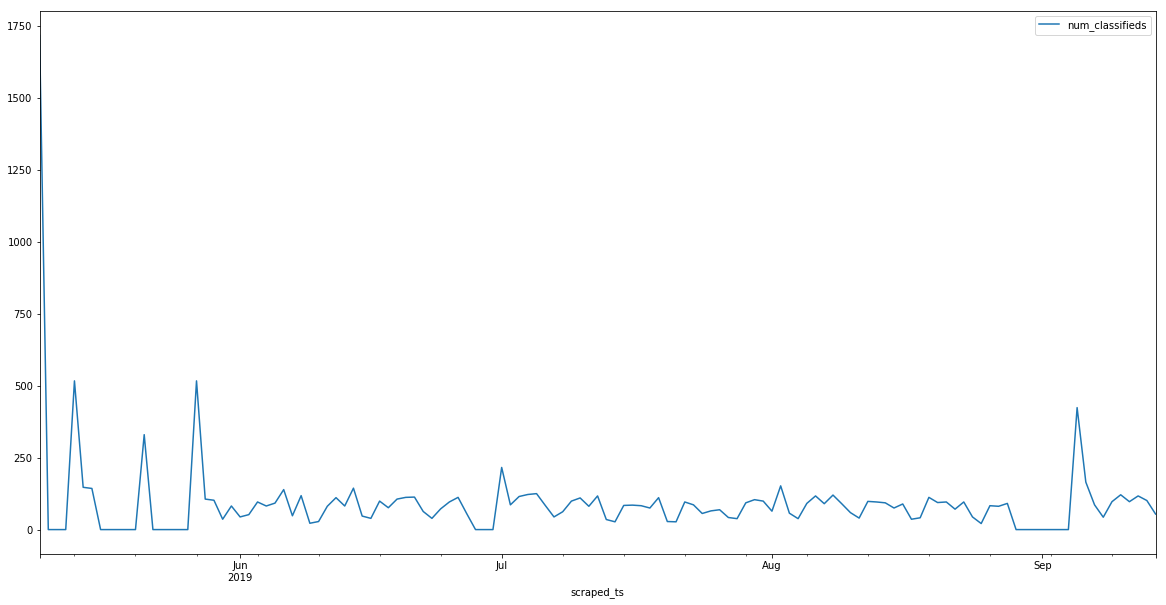

In [3]:
import matplotlib.pyplot as plt

scrape_freq = pd.DataFrame(realty_details_df.set_index('scraped_ts').groupby(pd.Grouper(freq='D')).count()['id'])
scrape_freq.columns = ['num_classifieds']
scrape_freq.plot.line(figsize=(20,10))

Ok, as we see in this plot the scraper is running since somewhere in may. At first some 1500 realties are scraped and doenloaded. Then, after a humble start the number of scraped classifieds stabilizes starting in June 2019. Since then the average numer of new classifieds per day is:

In [30]:
print(np.mean(scrape_freq.loc['2019-06-01':]))

num_classifieds    79.014085
dtype: float64


Since I am running the scraper once a day, and I know that it only scrapes new classifieds, 80 new realties per day seem plausible.
Now that we know the scraper does its job lets dig into the data. Lets calculate the rent per square meter for each realty and look at the aveage and mean:

In [40]:
realty_details_df['net_rent_per_m'] = realty_details_df['net_rent'] / realty_details_df['square_m']
realty_details_df.net_rent_per_m.describe()

count    9297.000000
mean      208.621589
std       445.592437
min         4.291845
25%        10.000000
50%        12.727273
75%        18.113109
max      3681.468653
Name: net_rent_per_m, dtype: float64

As you see, there is a total of 9297 classifieds in this dataset. Prices per square meter range from 4,29 EUR to 3681,46 EUR with an average price of 208,62 EUR. 

Hm, this seem more expensive than expected.

Lets dig deeper:

In [ ]:
realty_details_df['net_rent_per_m'].plot.line()

In [5]:
realty_details_df.set_index('scraped_ts').groupby(pd.TimeGrouper('D')).count()['id']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """Entry point for launching an IPython kernel.


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [ ]:
#######################################
# Make Data Profiling Report
#######################################



pandas_profiling.ProfileReport(realty_details_df)

In [ ]:
plot_data = realty_details_df[['city_county', 'city_quarter', 'street',
       'title', 'realty_type', 'floor', 'square_m', 'storage_m', 'num_rooms',
       'num_bedrooms', 'num_baths', 'num_carparks', 'year_built',
       'last_refurb', 'quality', 'heating_type', 'fuel_type',
       'energy_consumption', 'energy_class', 'net_rent', 'gross_rent', 'net_rent_per_m']]


In [ ]:
import seaborn as sns



corr = plot_data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

corr

In [ ]:
sns.lmplot(x="gross_rent", y="square_m", data=plot_data[['gross_rent', 'square_m']])

In [ ]:
from pandas.plotting import scatter_matrix


x = scatter_matrix(plot_data, alpha=0.2, figsize=(20, 20), diagonal='hist')

In [ ]:
plot_data